In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import sys
import itertools
sys.path.append('src/')
import nn
import process_data
import nibabel as nib
from math import floor, ceil
from sklearn.metrics import confusion_matrix
import scipy.sparse
from scipy.misc import imrotate, imresize
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate
from skimage import exposure, data
from skimage.io import imread, imsave
import pipeline
import Unet

In [2]:
def elastic_transform(image, alpha, sigma, rand_arr1, rand_arr2):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    shape = image.shape

    dx = gaussian_filter((rand_arr1 * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((rand_arr2 * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [25]:
def elastic_transform_nifti(nifti_vol_arr, nifti_seg_arr, alpha, sigma):
    shape = nifti_vol_arr.shape
    transformed_vol_arr = np.empty(shape)
    transformed_seg_arr = np.empty(shape)
    seed = np.random.randint(0, 2 ** 32 - 1)
    randomizer = np.random.RandomState(seed)
    for i in range(shape[0]):
        print(i, end='; ')
        curr_vol_slice, curr_seg_slice = nifti_vol_arr[i], nifti_seg_arr[i]
        rand_arr1 = randomizer.rand(*shape)
        rand_arr2 = randomizer.rand(*shape)
        print("About to transform vol slice;", end=' ')
        transformed_vol_slice = elastic_transform(curr_vol_slice, alpha, sigma, rand_arr1, rand_arr2)
        print("About to transform seg slice;", end=' ')
        transformed_seg_slice = elastic_transform(curr_seg_slice, alpha, sigma, rand_arr1, rand_arr2)
        print("Done with transformations;", end=' ')
        transformed_vol_arr[i] = transformed_vol_slice
        transformed_seg_arr[i] = transformed_seg_slice
        print(' ')
    return transformed_vol_arr, transformed_seg_arr

In [4]:
nii_data_dir = "/Users/nozik/Documents/HARTresearch/allrawnifti"
nii_vol_name = "trial8_30_fs_volume_TRANS.nii"
nii_seg_name = "trial8_30_fs_seg_ak5_lh4_TRANS.nii"

In [5]:
nii_vol = nib.load(os.path.join(nii_data_dir, nii_vol_name))
nii_seg = nib.load(os.path.join(nii_data_dir, nii_seg_name))

In [11]:
nii_vol_arr = nii_vol.get_fdata()
nii_seg_arr = nii_seg.get_fdata()

In [12]:
print(nii_vol_arr.shape, nii_seg_arr.shape)

(1188, 482, 395) (1188, 482, 395)


In [76]:
print(np.unique(nii_seg_arr).shape)

(9,)


In [24]:
transformed_vol_arr, transformed_seg_arr = elastic_transform_nifti(nii_vol_arr, nii_seg_arr, 34, 8)

0
About to transform vol slice;


KeyboardInterrupt: 

In [14]:
eximage = nii_vol_arr[500]

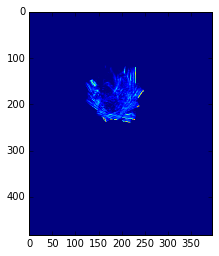

In [15]:
plt.imshow(eximage)

In [92]:
seed = np.random.randint(0, 2 ** 32 - 1)
randomizer = np.random.RandomState(seed)
shape = eximage.shape
rand_arr1 = randomizer.rand(*shape)
rand_arr2 = randomizer.rand(*shape)
deformed = elastic_transform(eximage, 0, 1, rand_arr1, rand_arr2)

True


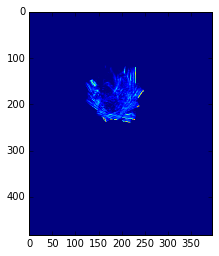

In [93]:
plt.imshow(deformed)
print(np.unique(eximage).shape == np.unique(deformed).shape)

In [77]:
def elastic_transform_nifti(nifti_vol_arr, nifti_seg_arr, alpha, sigma):
    transformed_vol_arr = np.empty(nifti_vol_arr.shape)
    transformed_seg_arr = np.empty(nifti_seg_arr.shape)
    seed = np.random.randint(0, 2 ** 32 - 1)
    randomizer = np.random.RandomState(seed)
    for i in range(nifti_vol_arr.shape[0]):
        print(i, end='; ')
        rand_arr1 = randomizer.rand(*nifti_vol_arr[i].shape)
        rand_arr2 = randomizer.rand(*nifti_vol_arr[i].shape)
        print("About to transform vol slice;", end=' ')
        transformed_vol_slice = elastic_transform(nifti_vol_arr[i], alpha, sigma, rand_arr1, rand_arr2)
        print("About to transform seg slice;", end=' ')
        transformed_seg_slice = elastic_transform(nifti_seg_arr[i], alpha, sigma, rand_arr1, rand_arr2)
        print("Done with transformations;", end=' ')
        transformed_vol_arr[i] = transformed_vol_slice
        transformed_seg_arr[i] = transformed_seg_slice
        print(' ')
    return transformed_vol_arr, transformed_seg_arr

transformed_vol_arr, transformed_seg_arr = elastic_transform_nifti(nii_vol_arr, nii_seg_arr, 34, 1)

0; About to transform vol slice; About to transform seg slice; Done with transformations;  
1; About to transform vol slice; About to transform seg slice; Done with transformations;  
2; About to transform vol slice; About to transform seg slice; Done with transformations;  
3; About to transform vol slice; About to transform seg slice; Done with transformations;  
4; About to transform vol slice; About to transform seg slice; Done with transformations;  
5; About to transform vol slice; About to transform seg slice; Done with transformations;  
6; About to transform vol slice; About to transform seg slice; Done with transformations;  
7; About to transform vol slice; About to transform seg slice; Done with transformations;  
8; About to transform vol slice; About to transform seg slice; Done with transformations;  
9; About to transform vol slice; About to transform seg slice; Done with transformations;  
10; About to transform vol slice; About to transform seg slice; Done with transf

88; About to transform vol slice; About to transform seg slice; Done with transformations;  
89; About to transform vol slice; About to transform seg slice; Done with transformations;  
90; About to transform vol slice; About to transform seg slice; Done with transformations;  
91; About to transform vol slice; About to transform seg slice; Done with transformations;  
92; About to transform vol slice; About to transform seg slice; Done with transformations;  
93; About to transform vol slice; About to transform seg slice; Done with transformations;  
94; About to transform vol slice; About to transform seg slice; Done with transformations;  
95; About to transform vol slice; About to transform seg slice; Done with transformations;  
96; About to transform vol slice; About to transform seg slice; Done with transformations;  
97; About to transform vol slice; About to transform seg slice; Done with transformations;  
98; About to transform vol slice; About to transform seg slice; Done w

175; About to transform vol slice; About to transform seg slice; Done with transformations;  
176; About to transform vol slice; About to transform seg slice; Done with transformations;  
177; About to transform vol slice; About to transform seg slice; Done with transformations;  
178; About to transform vol slice; About to transform seg slice; Done with transformations;  
179; About to transform vol slice; About to transform seg slice; Done with transformations;  
180; About to transform vol slice; About to transform seg slice; Done with transformations;  
181; About to transform vol slice; About to transform seg slice; Done with transformations;  
182; About to transform vol slice; About to transform seg slice; Done with transformations;  
183; About to transform vol slice; About to transform seg slice; Done with transformations;  
184; About to transform vol slice; About to transform seg slice; Done with transformations;  
185; About to transform vol slice; About to transform seg sl

263; About to transform vol slice; About to transform seg slice; Done with transformations;  
264; About to transform vol slice; About to transform seg slice; Done with transformations;  
265; About to transform vol slice; About to transform seg slice; Done with transformations;  
266; About to transform vol slice; About to transform seg slice; Done with transformations;  
267; About to transform vol slice; About to transform seg slice; Done with transformations;  
268; About to transform vol slice; About to transform seg slice; Done with transformations;  
269; About to transform vol slice; About to transform seg slice; Done with transformations;  
270; About to transform vol slice; About to transform seg slice; Done with transformations;  
271; About to transform vol slice; About to transform seg slice; Done with transformations;  
272; About to transform vol slice; About to transform seg slice; Done with transformations;  
273; About to transform vol slice; About to transform seg sl

352; About to transform vol slice; About to transform seg slice; Done with transformations;  
353; About to transform vol slice; About to transform seg slice; Done with transformations;  
354; About to transform vol slice; About to transform seg slice; Done with transformations;  
355; About to transform vol slice; About to transform seg slice; Done with transformations;  
356; About to transform vol slice; About to transform seg slice; Done with transformations;  
357; About to transform vol slice; About to transform seg slice; Done with transformations;  
358; About to transform vol slice; About to transform seg slice; Done with transformations;  
359; About to transform vol slice; About to transform seg slice; Done with transformations;  
360; About to transform vol slice; About to transform seg slice; Done with transformations;  
361; About to transform vol slice; About to transform seg slice; Done with transformations;  
362; About to transform vol slice; About to transform seg sl

440; About to transform vol slice; About to transform seg slice; Done with transformations;  
441; About to transform vol slice; About to transform seg slice; Done with transformations;  
442; About to transform vol slice; About to transform seg slice; Done with transformations;  
443; About to transform vol slice; About to transform seg slice; Done with transformations;  
444; About to transform vol slice; About to transform seg slice; Done with transformations;  
445; About to transform vol slice; About to transform seg slice; Done with transformations;  
446; About to transform vol slice; About to transform seg slice; Done with transformations;  
447; About to transform vol slice; About to transform seg slice; Done with transformations;  
448; About to transform vol slice; About to transform seg slice; Done with transformations;  
449; About to transform vol slice; About to transform seg slice; Done with transformations;  
450; About to transform vol slice; About to transform seg sl

528; About to transform vol slice; About to transform seg slice; Done with transformations;  
529; About to transform vol slice; About to transform seg slice; Done with transformations;  
530; About to transform vol slice; About to transform seg slice; Done with transformations;  
531; About to transform vol slice; About to transform seg slice; Done with transformations;  
532; About to transform vol slice; About to transform seg slice; Done with transformations;  
533; About to transform vol slice; About to transform seg slice; Done with transformations;  
534; About to transform vol slice; About to transform seg slice; Done with transformations;  
535; About to transform vol slice; About to transform seg slice; Done with transformations;  
536; About to transform vol slice; About to transform seg slice; Done with transformations;  
537; About to transform vol slice; About to transform seg slice; Done with transformations;  
538; About to transform vol slice; About to transform seg sl

616; About to transform vol slice; About to transform seg slice; Done with transformations;  
617; About to transform vol slice; About to transform seg slice; Done with transformations;  
618; About to transform vol slice; About to transform seg slice; Done with transformations;  
619; About to transform vol slice; About to transform seg slice; Done with transformations;  
620; About to transform vol slice; About to transform seg slice; Done with transformations;  
621; About to transform vol slice; About to transform seg slice; Done with transformations;  
622; About to transform vol slice; About to transform seg slice; Done with transformations;  
623; About to transform vol slice; About to transform seg slice; Done with transformations;  
624; About to transform vol slice; About to transform seg slice; Done with transformations;  
625; About to transform vol slice; About to transform seg slice; Done with transformations;  
626; About to transform vol slice; About to transform seg sl

705; About to transform vol slice; About to transform seg slice; Done with transformations;  
706; About to transform vol slice; About to transform seg slice; Done with transformations;  
707; About to transform vol slice; About to transform seg slice; Done with transformations;  
708; About to transform vol slice; About to transform seg slice; Done with transformations;  
709; About to transform vol slice; About to transform seg slice; Done with transformations;  
710; About to transform vol slice; About to transform seg slice; Done with transformations;  
711; About to transform vol slice; About to transform seg slice; Done with transformations;  
712; About to transform vol slice; About to transform seg slice; Done with transformations;  
713; About to transform vol slice; About to transform seg slice; Done with transformations;  
714; About to transform vol slice; About to transform seg slice; Done with transformations;  
715; About to transform vol slice; About to transform seg sl

794; About to transform vol slice; About to transform seg slice; Done with transformations;  
795; About to transform vol slice; About to transform seg slice; Done with transformations;  
796; About to transform vol slice; About to transform seg slice; Done with transformations;  
797; About to transform vol slice; About to transform seg slice; Done with transformations;  
798; About to transform vol slice; About to transform seg slice; Done with transformations;  
799; About to transform vol slice; About to transform seg slice; Done with transformations;  
800; About to transform vol slice; About to transform seg slice; Done with transformations;  
801; About to transform vol slice; About to transform seg slice; Done with transformations;  
802; About to transform vol slice; About to transform seg slice; Done with transformations;  
803; About to transform vol slice; About to transform seg slice; Done with transformations;  
804; About to transform vol slice; About to transform seg sl

882; About to transform vol slice; About to transform seg slice; Done with transformations;  
883; About to transform vol slice; About to transform seg slice; Done with transformations;  
884; About to transform vol slice; About to transform seg slice; Done with transformations;  
885; About to transform vol slice; About to transform seg slice; Done with transformations;  
886; About to transform vol slice; About to transform seg slice; Done with transformations;  
887; About to transform vol slice; About to transform seg slice; Done with transformations;  
888; About to transform vol slice; About to transform seg slice; Done with transformations;  
889; About to transform vol slice; About to transform seg slice; Done with transformations;  
890; About to transform vol slice; About to transform seg slice; Done with transformations;  
891; About to transform vol slice; About to transform seg slice; Done with transformations;  
892; About to transform vol slice; About to transform seg sl

970; About to transform vol slice; About to transform seg slice; Done with transformations;  
971; About to transform vol slice; About to transform seg slice; Done with transformations;  
972; About to transform vol slice; About to transform seg slice; Done with transformations;  
973; About to transform vol slice; About to transform seg slice; Done with transformations;  
974; About to transform vol slice; About to transform seg slice; Done with transformations;  
975; About to transform vol slice; About to transform seg slice; Done with transformations;  
976; About to transform vol slice; About to transform seg slice; Done with transformations;  
977; About to transform vol slice; About to transform seg slice; Done with transformations;  
978; About to transform vol slice; About to transform seg slice; Done with transformations;  
979; About to transform vol slice; About to transform seg slice; Done with transformations;  
980; About to transform vol slice; About to transform seg sl

1056; About to transform vol slice; About to transform seg slice; Done with transformations;  
1057; About to transform vol slice; About to transform seg slice; Done with transformations;  
1058; About to transform vol slice; About to transform seg slice; Done with transformations;  
1059; About to transform vol slice; About to transform seg slice; Done with transformations;  
1060; About to transform vol slice; About to transform seg slice; Done with transformations;  
1061; About to transform vol slice; About to transform seg slice; Done with transformations;  
1062; About to transform vol slice; About to transform seg slice; Done with transformations;  
1063; About to transform vol slice; About to transform seg slice; Done with transformations;  
1064; About to transform vol slice; About to transform seg slice; Done with transformations;  
1065; About to transform vol slice; About to transform seg slice; Done with transformations;  
1066; About to transform vol slice; About to trans

1144; About to transform vol slice; About to transform seg slice; Done with transformations;  
1145; About to transform vol slice; About to transform seg slice; Done with transformations;  
1146; About to transform vol slice; About to transform seg slice; Done with transformations;  
1147; About to transform vol slice; About to transform seg slice; Done with transformations;  
1148; About to transform vol slice; About to transform seg slice; Done with transformations;  
1149; About to transform vol slice; About to transform seg slice; Done with transformations;  
1150; About to transform vol slice; About to transform seg slice; Done with transformations;  
1151; About to transform vol slice; About to transform seg slice; Done with transformations;  
1152; About to transform vol slice; About to transform seg slice; Done with transformations;  
1153; About to transform vol slice; About to transform seg slice; Done with transformations;  
1154; About to transform vol slice; About to trans

In [66]:
nii_save_dir = "/Users/nozik/Documents/HARTresearch/augmented_data/elastic_transformed_nii"

In [78]:
pipeline.save_arr_as_nifti(transformed_vol_arr, nii_vol_name, "trial8_30_fs_vol_elast_3.nii", nii_data_dir, nii_save_dir)
pipeline.save_arr_as_nifti(transformed_seg_arr, nii_seg_name, "trial8_30_fs_seg_elast_3.nii", nii_data_dir, nii_save_dir)

In [72]:
np.unique(transformed_seg_arr).shape

(2084123,)

In [74]:
np.unique(nii_seg_arr).shape

(9,)